## Implementation
A GRID_SIZE x GRID_SIZE grid with random obstacles and defined start and goal states.

A reward() function rewards reaching the goal, penalizes obstacles, and slightly penalizes each movement.

Compared with 100x100 and 25x25 grids.

Value Iteration (DP):
Computes values by iterating over all states and actions, propagating rewards to converge on optimal state values.

Q-Learning:
A model-free off-policy RL algorithm that updates Q-values by selecting the maximum action value from the next state.
Uses exploration-exploitation trade-off to improve the policy over time.

SARSA:
An on-policy method that learns action values based on the policy being followed (choosing actions with the highest Q-values).
Updates Q-values using the state-action pair based on the current policy.

In [99]:
import numpy as np
import random
import time
import matplotlib.pyplot as plt

# Initialize constants
GRID_SIZE = 100
NUM_OBSTACLES = 3800
ACTION_SPACE = ['UP', 'DOWN', 'LEFT', 'RIGHT']
GAMMA = 0.9
THETA = 1e-4
ALPHA = 0.1
EPSILON = 0.1
EPISODES = 500000
MAX_STEPS = 500

# Environment Setup
def create_grid():
    grid = np.zeros((GRID_SIZE, GRID_SIZE))
    for _ in range(NUM_OBSTACLES):
        x, y = random.randint(0, GRID_SIZE - 1), random.randint(0, GRID_SIZE - 1)
        grid[x, y] = 1  # 1 represents an obstacle
    return grid

def initialize_start_goal(grid):
    start, goal = (0, 0), (GRID_SIZE - 1, GRID_SIZE - 1)
    while grid[start] == 1:
        start = (random.randint(0, GRID_SIZE - 1), random.randint(0, GRID_SIZE - 1))
    while grid[goal] == 1:
        goal = (random.randint(0, GRID_SIZE - 1), random.randint(0, GRID_SIZE - 1))
    return start, goal

# Transition Model
def transition(state, action):
    x, y = state
    if action == 'UP':
        next_state = (max(x - 1, 0), y)
    elif action == 'DOWN':
        next_state = (min(x + 1, GRID_SIZE - 1), y)
    elif action == 'LEFT':
        next_state = (x, max(y - 1, 0))
    elif action == 'RIGHT':
        next_state = (x, min(y + 1, GRID_SIZE - 1))
    return next_state if grid[next_state] == 0 else state

# Reward Function
def reward(state):
    if state == goal:
        return 10
    elif grid[state] == 1:
        return -10
    else:
        return -1

# DP - Value Iteration
def value_iteration():
    V = np.zeros((GRID_SIZE, GRID_SIZE))
    policy = np.zeros((GRID_SIZE, GRID_SIZE), dtype=int)
    for i in range(100):
        delta = 0
        for x in range(GRID_SIZE):
            for y in range(GRID_SIZE):
                state = (x, y)
                if state == goal:
                    continue
                v = V[state]
                action_values = [reward(state) + GAMMA * V[transition(state, a)] for a in ACTION_SPACE]
                best_action = np.argmax(action_values)
                V[state] = action_values[best_action]
                policy[state] = best_action
                delta = max(delta, abs(v - V[state]))
        if delta < THETA:
            break
    return policy

# Q-Learning
def q_learning():
    Q = np.zeros((GRID_SIZE, GRID_SIZE, len(ACTION_SPACE)))
    for episode in range(EPISODES):
        state = start
        for _ in range(MAX_STEPS):
            if random.uniform(0, 1) < EPSILON:
                action = random.choice(range(len(ACTION_SPACE)))
            else:
                action = np.argmax(Q[state[0], state[1]])
            next_state = transition(state, ACTION_SPACE[action])
            reward_value = reward(next_state)
            best_next_action = np.argmax(Q[next_state[0], next_state[1]])
            Q[state[0], state[1], action] += ALPHA * (reward_value + GAMMA * Q[next_state[0], next_state[1], best_next_action] - Q[state[0], state[1], action])
            state = next_state
            if state == goal:
                break
    policy = np.argmax(Q, axis=2)
    return policy

# SARSA
def sarsa():
    Q = np.zeros((GRID_SIZE, GRID_SIZE, len(ACTION_SPACE)))
    for episode in range(EPISODES):
        state = start
        action = np.argmax(Q[state[0], state[1]]) if random.uniform(0, 1) > EPSILON else random.choice(range(len(ACTION_SPACE)))
        for _ in range(MAX_STEPS):
            next_state = transition(state, ACTION_SPACE[action])
            reward_value = reward(next_state)
            next_action = np.argmax(Q[next_state[0], next_state[1]]) if random.uniform(0, 1) > EPSILON else random.choice(range(len(ACTION_SPACE)))
            Q[state[0], state[1], action] += ALPHA * (reward_value + GAMMA * Q[next_state[0], next_state[1], next_action] - Q[state[0], state[1], action])
            state, action = next_state, next_action
            if state == goal:
                break
    policy = np.argmax(Q, axis=2)
    return policy

# Function to simulate and plot path taken
def simulate_and_plot(policy, method_name):
    start_time = time.time()
    state = start
    path = [state]
    total_reward = 0
    for _ in range(MAX_STEPS):
        action = policy[state[0], state[1]]
        next_state = transition(state, ACTION_SPACE[action])
        path.append(next_state)
        total_reward += reward(next_state)
        state = next_state
        if state == goal:
            break

    # Time taken
    end_time = time.time()
    time_taken = end_time - start_time
    steps_taken = len(path) - 1  # exclude the start state

    # Plotting
    plt.figure(figsize=(8, 8))
    plt.imshow(grid, cmap='gray_r')
    plt.scatter(start[1], start[0], color='green', s=100, label='Start')
    plt.scatter(goal[1], goal[0], color='red', s=100, label='Goal')
    path_x, path_y = zip(*path)
    plt.plot(path_y, path_x, marker='o', color='blue', label='Path')
    plt.title(f"Path taken by {method_name}")
    plt.legend()
    plt.show()

    # Print statistics
    print(f"\nMethod: {method_name}")
    print(f"Time taken: {time_taken:.4f} seconds")
    print(f"Number of steps to goal: {steps_taken}")
    print(f"Total reward: {total_reward}")



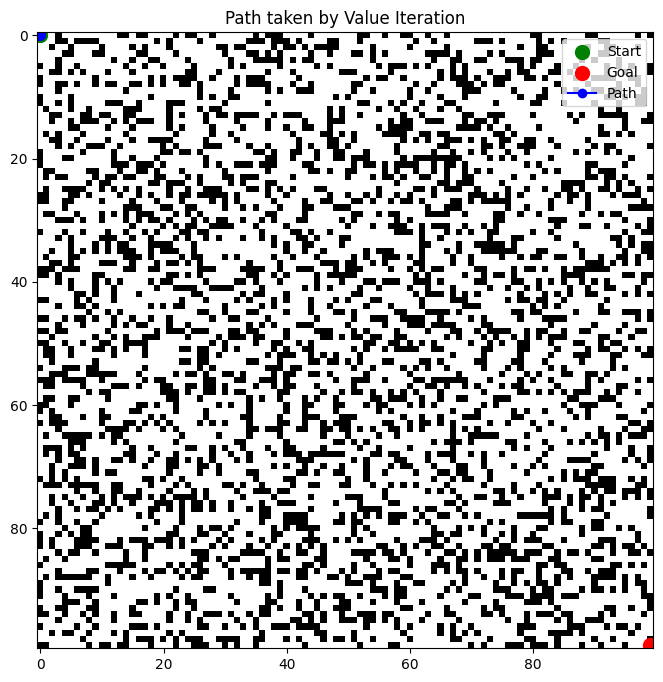


Method: Value Iteration
Time taken: 0.0010 seconds
Number of steps to goal: 500
Total reward: -500


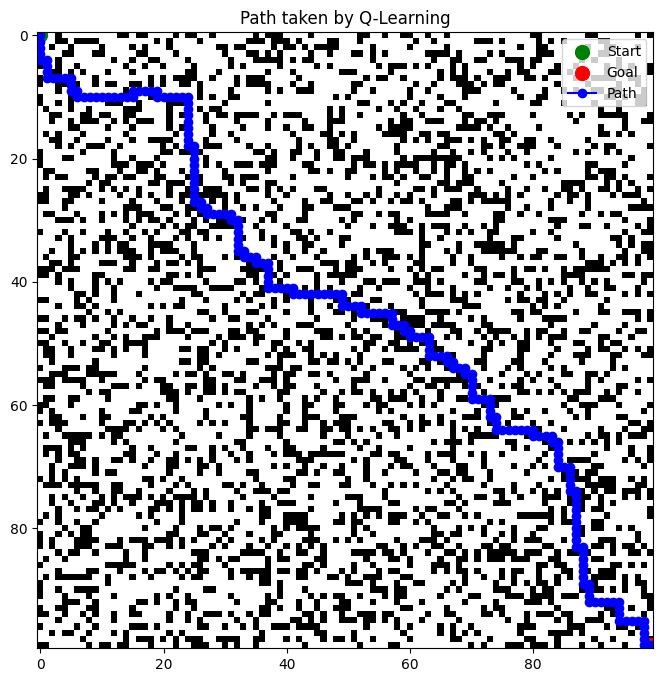


Method: Q-Learning
Time taken: 0.0000 seconds
Number of steps to goal: 200
Total reward: -189


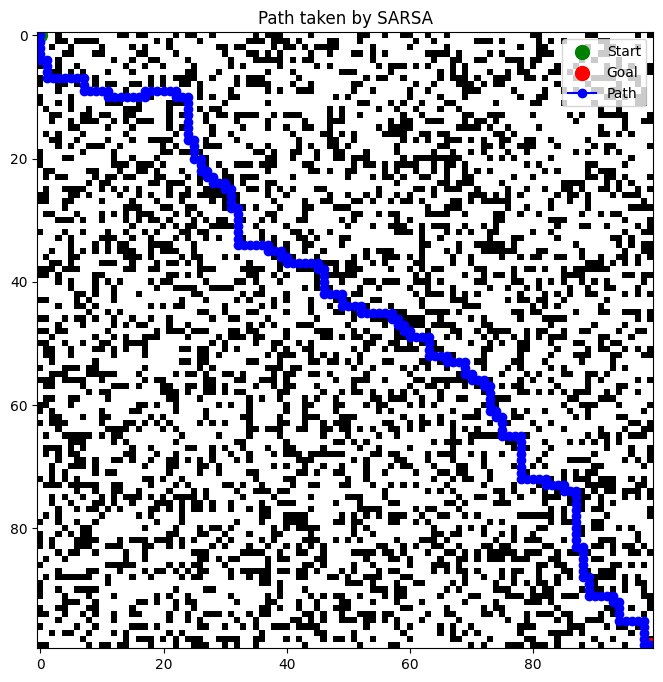


Method: SARSA
Time taken: 0.0100 seconds
Number of steps to goal: 200
Total reward: -189


In [100]:
# Benchmarking and Visualization
grid = create_grid()
start, goal = initialize_start_goal(grid)

# Run and plot results for each method
methods = {"Value Iteration": value_iteration, "Q-Learning": q_learning, "SARSA": sarsa}
for method_name, method_func in methods.items():
    policy = method_func()
    simulate_and_plot(policy, method_name)


In [103]:
import numpy as np
import random
import time
import matplotlib.pyplot as plt

# Initialize constants
GRID_SIZE = 25
NUM_OBSTACLES = 70
ACTION_SPACE = ['UP', 'DOWN', 'LEFT', 'RIGHT']
GAMMA = 0.9
THETA = 1e-4
ALPHA = 0.1
EPSILON = 0.1
EPISODES = 500000
MAX_STEPS = 500

# Environment Setup
def create_grid():
    grid = np.zeros((GRID_SIZE, GRID_SIZE))
    for _ in range(NUM_OBSTACLES):
        x, y = random.randint(0, GRID_SIZE - 1), random.randint(0, GRID_SIZE - 1)
        grid[x, y] = 1  # 1 represents an obstacle
    return grid

def initialize_start_goal(grid):
    start, goal = (0, 0), (GRID_SIZE - 1, GRID_SIZE - 1)
    while grid[start] == 1:
        start = (random.randint(0, GRID_SIZE - 1), random.randint(0, GRID_SIZE - 1))
    while grid[goal] == 1:
        goal = (random.randint(0, GRID_SIZE - 1), random.randint(0, GRID_SIZE - 1))
    return start, goal

# Transition Model
def transition(state, action):
    x, y = state
    if action == 'UP':
        next_state = (max(x - 1, 0), y)
    elif action == 'DOWN':
        next_state = (min(x + 1, GRID_SIZE - 1), y)
    elif action == 'LEFT':
        next_state = (x, max(y - 1, 0))
    elif action == 'RIGHT':
        next_state = (x, min(y + 1, GRID_SIZE - 1))
    return next_state if grid[next_state] == 0 else state

# Reward Function
def reward(state):
    if state == goal:
        return 10
    elif grid[state] == 1:
        return -10
    else:
        return -1

# DP - Value Iteration
def value_iteration():
    V = np.zeros((GRID_SIZE, GRID_SIZE))
    policy = np.zeros((GRID_SIZE, GRID_SIZE), dtype=int)
    for i in range(100):
        delta = 0
        for x in range(GRID_SIZE):
            for y in range(GRID_SIZE):
                state = (x, y)
                if state == goal:
                    continue
                v = V[state]
                action_values = [reward(state) + GAMMA * V[transition(state, a)] for a in ACTION_SPACE]
                best_action = np.argmax(action_values)
                V[state] = action_values[best_action]
                policy[state] = best_action
                delta = max(delta, abs(v - V[state]))
        if delta < THETA:
            break
    return policy

# Q-Learning
def q_learning():
    Q = np.zeros((GRID_SIZE, GRID_SIZE, len(ACTION_SPACE)))
    for episode in range(EPISODES):
        state = start
        for _ in range(MAX_STEPS):
            if random.uniform(0, 1) < EPSILON:
                action = random.choice(range(len(ACTION_SPACE)))
            else:
                action = np.argmax(Q[state[0], state[1]])
            next_state = transition(state, ACTION_SPACE[action])
            reward_value = reward(next_state)
            best_next_action = np.argmax(Q[next_state[0], next_state[1]])
            Q[state[0], state[1], action] += ALPHA * (reward_value + GAMMA * Q[next_state[0], next_state[1], best_next_action] - Q[state[0], state[1], action])
            state = next_state
            if state == goal:
                break
    policy = np.argmax(Q, axis=2)
    return policy

# SARSA
def sarsa():
    Q = np.zeros((GRID_SIZE, GRID_SIZE, len(ACTION_SPACE)))
    for episode in range(EPISODES):
        state = start
        action = np.argmax(Q[state[0], state[1]]) if random.uniform(0, 1) > EPSILON else random.choice(range(len(ACTION_SPACE)))
        for _ in range(MAX_STEPS):
            next_state = transition(state, ACTION_SPACE[action])
            reward_value = reward(next_state)
            next_action = np.argmax(Q[next_state[0], next_state[1]]) if random.uniform(0, 1) > EPSILON else random.choice(range(len(ACTION_SPACE)))
            Q[state[0], state[1], action] += ALPHA * (reward_value + GAMMA * Q[next_state[0], next_state[1], next_action] - Q[state[0], state[1], action])
            state, action = next_state, next_action
            if state == goal:
                break
    policy = np.argmax(Q, axis=2)
    return policy

# Function to simulate and plot path taken
def simulate_and_plot(policy, method_name):
    start_time = time.time()
    state = start
    path = [state]
    total_reward = 0
    for _ in range(MAX_STEPS):
        action = policy[state[0], state[1]]
        next_state = transition(state, ACTION_SPACE[action])
        path.append(next_state)
        total_reward += reward(next_state)
        state = next_state
        if state == goal:
            break

    # Time taken
    end_time = time.time()
    time_taken = end_time - start_time
    steps_taken = len(path) - 1  # exclude the start state

    # Plotting
    plt.figure(figsize=(8, 8))
    plt.imshow(grid, cmap='gray_r')
    plt.scatter(start[1], start[0], color='green', s=100, label='Start')
    plt.scatter(goal[1], goal[0], color='red', s=100, label='Goal')
    path_x, path_y = zip(*path)
    plt.plot(path_y, path_x, marker='o', color='blue', label='Path')
    plt.title(f"Path taken by {method_name}")
    plt.legend()
    plt.show()

    # Print statistics
    print(f"\nMethod: {method_name}")
    print(f"Time taken: {time_taken:.4f} seconds")
    print(f"Number of steps to goal: {steps_taken}")
    print(f"Total reward: {total_reward}")



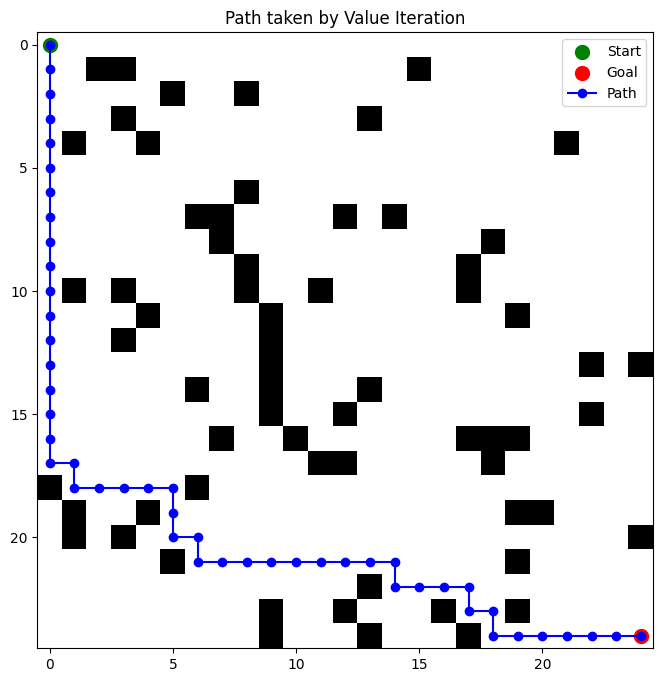


Method: Value Iteration
Time taken: 0.0000 seconds
Number of steps to goal: 48
Total reward: -37


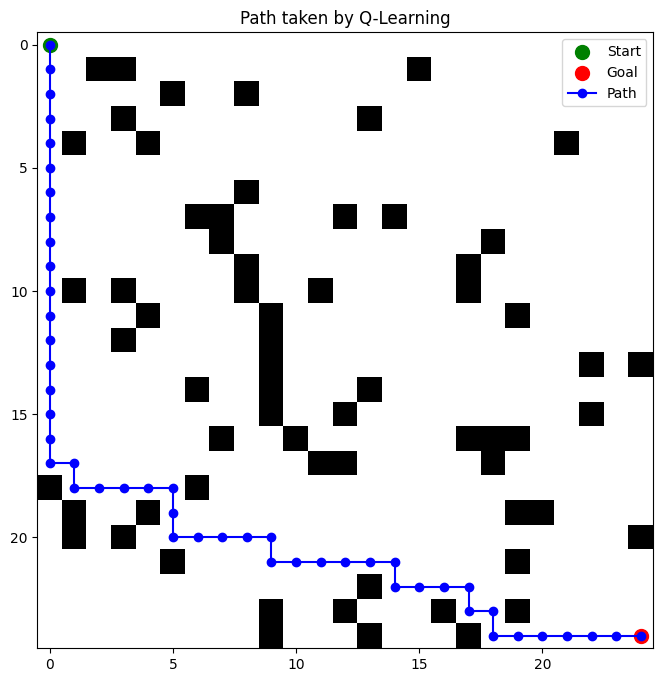


Method: Q-Learning
Time taken: 0.0000 seconds
Number of steps to goal: 48
Total reward: -37


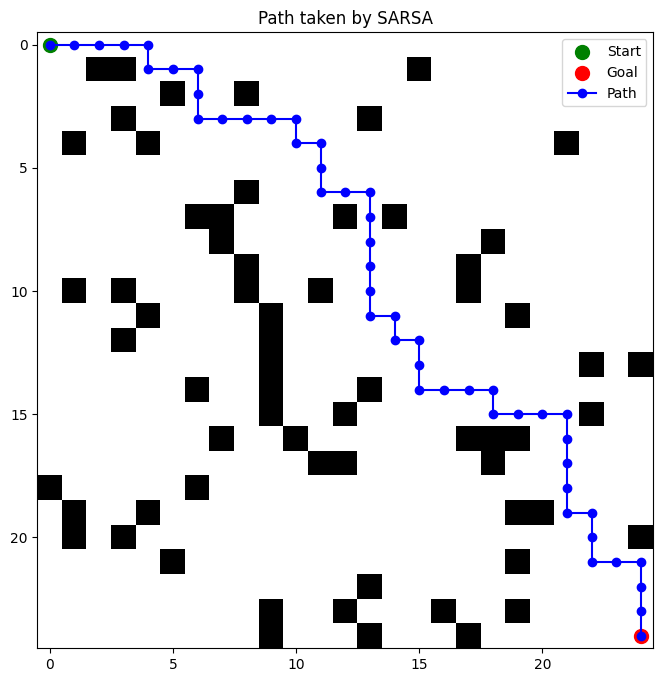


Method: SARSA
Time taken: 0.0000 seconds
Number of steps to goal: 48
Total reward: -37


In [104]:
# Benchmarking and Visualization
grid = create_grid()
start, goal = initialize_start_goal(grid)

# Run and plot results for each method
methods = {"Value Iteration": value_iteration, "Q-Learning": q_learning, "SARSA": sarsa}
for method_name, method_func in methods.items():
    policy = method_func()
    simulate_and_plot(policy, method_name)

## Benchmarking and Results:
Measured time taken for each algorithm to converge and outputs partial results for comparison.
Analysis and Comparison

Time Performance:
Dynamic Programming (Value Iteration) is faster for small grids since it’s a systematic approach.
Q-Learning and SARSA can take longer but are more adaptable to different environments and scalable to more complex problems.

Policy Comparison:
Each method ultimately produce a policy leading from start to goal, though Q-Learning and SARSA’s policies can vary based on exploration settings (ε-greedy).

Scalability:
Value Iteration is more feasible for small grids. Q-Learning and SARSA are more adaptable to larger grids or continuous spaces (especially when enhanced with function approximators like neural networks).